In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

In [2]:
# from google.colab import files
# uploaded = files.upload()

In [3]:
# df = pd.read_csv('contract_awards_in_investment_project_financing_09-10-2024.csv')
# df.head()          

df = pd.read_csv('Data/contract_awards_in_investment_project_financing_09-10-2024.csv')
df.head()

,As of Date,Fiscal Year,Region,Borrower Country / Economy,Borrower Country / Economy Code,Project ID,Project Name,Project Global Practice,Procurement Category,Procurement Method,WB Contract Number,Contract Description,Borrower Contract Reference Number,Contract Signing Date,Supplier ID,Supplier,Supplier Country / Economy,Supplier Country / Economy Code,Supplier Contract Amount (USD),Review type
0,10/09/2024 00:00:00,2017,SOUTH ASIA,Afghanistan,AF,P120397,Afghanistan Agricultural Inputs Project (AAIP),"Agriculture, Fishing and Forestry;Industry, Tr...",Consultant Services,Individual Consultant Selection,1318576,Legal Specialst for Quarantine,MAIL/WB/IAIDS/IC/012,11/01/2016 00:00:00,192025.0,MR. LUTFULLAH SADAT,Afghanistan,AF,27006.76,Prior
1,10/09/2024 00:00:00,2017,MIDDLE EAST AND NORTH AFRICA,Lebanon,LB,P133226,Lebanon Fiscal Management Reform 2,Public Administration,Consultant Services,Individual Consultant Selection,1517913,Signed Contract relative to the PMU Positions ...,2,11/30/2016 00:00:00,173999.0,MARWAN TAMIM (MR.),Lebanon,LB,151200.00,Prior
2,10/09/2024 00:00:00,2017,MIDDLE EAST AND NORTH AFRICA,Lebanon,LB,P133226,Lebanon Fiscal Management Reform 2,Public Administration,Consultant Services,Individual Consultant Selection,1517959,Title on Consulting services as International ...,4,11/02/2016 00:00:00,166247.0,MOUNIR RACHED,Lebanon,LB,312000.00,Prior
3,10/09/2024 00:00:00,2017,MIDDLE EAST AND NORTH AFRICA,Lebanon,LB,P149242,Emergency National Poverty Targeting Program P...,Social Protection,Consultant Services,Direct Selection,1524264,Procurement Assistant - FOT,C-IC036,09/07/2016 00:00:00,178397.0,JESSY EL KHOURY,Lebanon,LB,76800.00,Prior
4,10/09/2024 00:00:00,2017,MIDDLE EAST AND NORTH AFRICA,Lebanon,LB,P149242,Emergency National Poverty Targeting Program P...,Social Protection,Consultant Services,Direct Selection,1524268,Procurement Specialist - FOT,C-IC035,09/07/2016 00:00:00,133992.0,NATHALIE GEBRAYEL,Lebanon,LB,195200.00,Prior


In [4]:

grouped_df = df.groupby(by = ['Project ID', 'WB Contract Number'])['Supplier Contract Amount (USD)'].sum().reset_index()
display(grouped_df)

,Project ID,WB Contract Number,Supplier Contract Amount (USD)
0,P050529,1540714,97000.00
1,P050529,1541294,80236.13
2,P050529,1541332,79969.00
3,P055120,1545554,901914.00
4,P064836,1545100,4293699.78
...,...,...,...
242435,P507066,1793773,48051.81
242436,P507066,1794892,14257.30
242437,P507066,1795803,1221688.96
242438,P507066,1796335,469908.62


Top borrowing/supplying countries
Trends spending by region/country/

In [5]:
new_rows = []
for index, row in df.iterrows():
    if ';' not in str(row['Project Global Practice']):
        new_rows.append(row)
        continue
    practices = str(row['Project Global Practice']).split(';')
    for practice in practices:
        new_row = row.copy()
        new_row['Project Global Practice'] = practice.strip()
        new_rows.append(new_row)

new_df = pd.DataFrame(new_rows)

In [6]:
new_df['Project Global Practice'].value_counts().head(20)

Project Global Practice
Agriculture, Fishing and Forestry              97805
Public Administration                          63206
Industry, Trade and Services                   57381
Social Protection                              45651
Water, Sanitation and Waste Management         42964
Education                                      39624
Transportation                                 35993
Health                                         35544
Information and Communications Technologies    31531
Energy and Extractives                         18119
Financial Sector                                6644
Name: count, dtype: int64


***1. Top 5 Borrowing Counteries***

In [7]:
# Create a df for top 5 top borrowing countries
df_countries = new_df.groupby('Borrower Country / Economy')['Supplier Contract Amount (USD)'].sum().reset_index()

df_countries = df_countries.sort_values(by='Supplier Contract Amount (USD)', ascending=False).reset_index(drop=True)
df_countries
df_top_countries = df_countries.sort_values('Supplier Contract Amount (USD)', ascending=False).reset_index(drop=True).head(5)
df_top_countries


,Borrower Country / Economy,Supplier Contract Amount (USD)
0,India,2.044646e+10
1,Pakistan,1.845833e+10
2,Bangladesh,1.007276e+10
3,China,9.183416e+09
4,Western and Central Africa,8.398149e+09


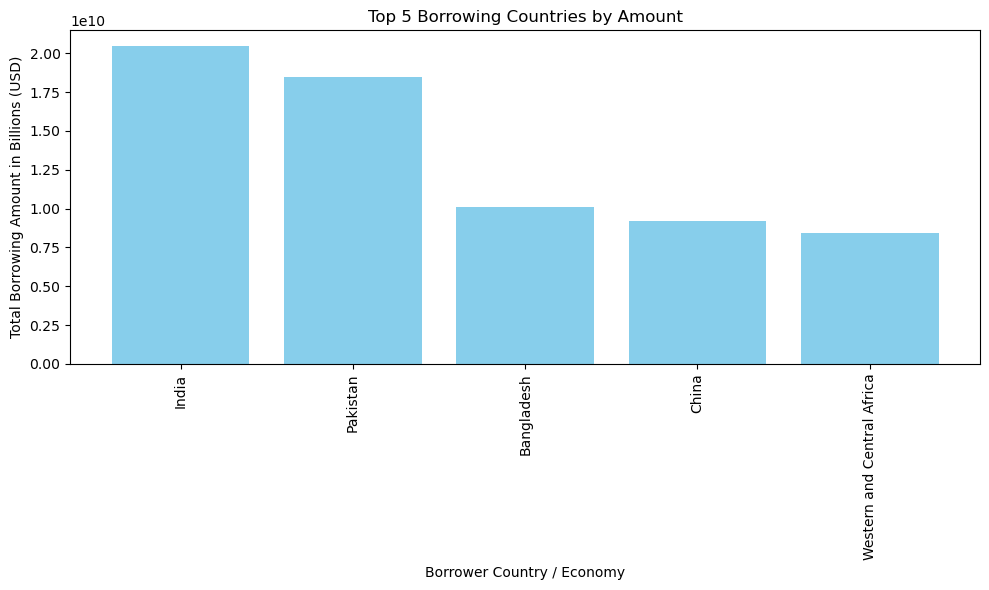

In [8]:
# Plot top 5 top borrowing countries
plt.figure(figsize=(10, 6))
plt.bar(df_top_countries['Borrower Country / Economy'], df_top_countries['Supplier Contract Amount (USD)'], color='skyblue')
plt.xlabel('Borrower Country / Economy')
plt.ylabel('Total Borrowing Amount in Billions (USD)')
plt.title('Top 5 Borrowing Countries by Amount')
plt.xticks(rotation=90)
top_countries = plt.tight_layout()
plt.tight_layout()
plt.show()

***2. Countries by borrowing money by year

In [9]:
# create a pivot df to see the sum of Supplier Contract Amount (USD) by  Borrower Country / Economy by year
pivot_df = pd.pivot_table(new_df, values='Supplier Contract Amount (USD)', index='Fiscal Year', columns='Borrower Country / Economy', aggfunc='sum')
pivot_df = pivot_df.sort_values(by=list(pivot_df.columns), ascending=False)
pivot_df = pivot_df.sort_index()
pivot_df


Borrower Country / Economy,Afghanistan,Africa,Albania,Angola,Argentina,Armenia,Azerbaijan,Bangladesh,Belarus,Belize,...,Uzbekistan,Vanuatu,Vietnam,West Bank and Gaza,Western Balkans,Western and Central Africa,World,"Yemen, Republic of",Zambia,Zimbabwe
Fiscal Year,,,,,,,,,,,,,,,,,,,,,
2017,5.344141e+08,19568696.32,2.103315e+08,3.720866e+07,2.427006e+08,9.063492e+07,2.184883e+08,1.507886e+09,4.062079e+08,10216284.17,...,2.352484e+08,70029328.00,3.517336e+08,35398166.14,59520.50,6.206109e+08,592821.48,NaN,1.482779e+08,10731859.49
2018,3.028574e+08,4249712.06,5.885424e+07,1.552506e+08,8.263513e+08,5.076940e+07,9.029696e+07,1.133270e+09,6.222263e+06,3288582.49,...,6.081184e+07,23068073.90,3.589358e+08,6290217.49,15389420.02,3.352684e+08,618831.00,NaN,7.461990e+07,3222453.87
2019,8.758000e+08,100678.13,6.667323e+07,1.049747e+08,3.779283e+08,5.858146e+07,2.254262e+07,1.149102e+09,3.245993e+07,6180336.88,...,2.193787e+08,44913326.68,9.757706e+08,15254055.21,48518.73,6.437788e+08,83960.00,NaN,1.024030e+08,3550445.76
2020,3.453970e+08,NaN,1.848846e+08,2.366087e+08,2.373736e+08,6.136945e+07,6.585225e+06,1.623993e+09,4.790025e+07,3268882.79,...,3.809302e+08,57317398.64,1.279670e+09,18330786.38,5962839.53,6.126823e+08,224256.00,NaN,1.358987e+08,1816621.56
2021,3.181813e+08,NaN,1.041673e+08,1.628691e+08,9.876294e+07,9.090263e+07,6.374801e+07,1.119814e+09,2.354514e+08,3314006.45,...,2.244402e+08,69865438.03,1.506563e+09,24386434.32,2850109.54,1.096503e+09,716936.89,NaN,6.168675e+07,2657108.07
2022,3.086722e+06,NaN,6.463400e+07,3.670816e+08,1.472325e+09,1.164432e+08,3.158203e+08,1.756489e+09,6.519522e+07,2120892.25,...,4.313955e+08,18981222.88,1.832117e+09,51580461.81,8152235.68,1.309182e+09,942648.28,89250.00,1.025601e+08,3189529.35
2023,NaN,NaN,1.137420e+08,1.424339e+08,5.937037e+08,1.000431e+08,1.338070e+08,7.547567e+08,1.960000e+04,1802120.78,...,4.810522e+08,54896081.61,6.325398e+08,39197795.19,22607442.26,1.327851e+09,972281.98,312895.51,1.556280e+08,1481013.21
2024,5.592236e+05,NaN,2.091663e+07,1.009489e+08,9.843783e+07,8.980331e+07,1.058099e+08,1.017068e+09,NaN,5882549.25,...,3.381416e+08,17940418.40,9.816837e+07,66371856.90,98169146.08,2.345674e+09,134733.29,263956.05,1.023641e+08,1145092.43
2025,6.722842e+04,NaN,1.268951e+06,1.279878e+07,1.225665e+07,2.367349e+06,1.936315e+05,1.038341e+07,NaN,536059.78,...,5.955394e+07,299851.02,1.083618e+07,9563156.40,6572500.06,1.065983e+08,NaN,NaN,1.901086e+06,34698.00


In [10]:
# create a pivot df to see the sum of Supplier Contract Amount (USD) by  Borrower Country / Economy by year
# pivot_df = pd.pivot_table(new_df, values='Supplier Contract Amount (USD)', index='Fiscal Year', columns='Borrower Country / Economy', aggfunc='sum')
# pivot_df = pivot_df.fillna(0)
# pivot_df

In [11]:
#Index the pivot df  by year and then county by highest amount for top 5 countries

contract_amount = pd.pivot_table(new_df, values='Supplier Contract Amount (USD)', index=['Borrower Country / Economy', 'Fiscal Year'], aggfunc='sum')
# contract_amount = contract_amount.sort_values(by=['Fiscal Year', 'Supplier Contract Amount (USD)'], ascending=[True, False])
# contract_amount = contract_amount.groupby('Fiscal Year').head(5)
# contract_amount = contract_amount.rename(columns={'Borrower Country / Economy':'Country','Supplier Contract Amount (USD)':'Total Spending Amount'})
contract_amount

Supplier Contract Amount (USD)
Borrower Country / Economy Fiscal Year                                
Afghanistan                2017                           5.344141e+08
                           2018                           3.028574e+08
                           2019                           8.758000e+08
                           2020                           3.453970e+08
                           2021                           3.181813e+08
...                                                                ...
Zimbabwe                   2021                           2.657108e+06
                           2022                           3.189529e+06
                           2023                           1.481013e+06
                           2024                           1.145092e+06
                           2025                           3.469800e+04

[1243 rows x 1 columns]

In [12]:
supplier_count = pd.pivot_table(new_df, values='Supplier ID', index=['Borrower Country / Economy', 'Fiscal Year',], aggfunc='count')
# supplier_count = supplier_count.sort_values(by=['Fiscal Year', 'Supplier ID'], ascending=[True, False])
# supplier_count = supplier_count.groupby('Fiscal Year').head(5)
# supplier_count = supplier_count.rename(columns={'Supplier ID':'Supplier Count'})
supplier_count



Supplier ID
Borrower Country / Economy Fiscal Year             
Afghanistan                2017                 329
                           2018                 286
                           2019                 508
                           2020                 611
                           2021                1225
...                                             ...
Zimbabwe                   2021                  39
                           2022                  67
                           2023                  40
                           2024                  13
                           2025                   1

[1243 rows x 1 columns]

In [13]:
merged_df = pd.merge(contract_amount, supplier_count, how='left', on=['Borrower Country / Economy','Fiscal Year'])
merged_df.reset_index(inplace=True)
merged_df

,Borrower Country / Economy,Fiscal Year,Supplier Contract Amount (USD),Supplier ID
0,Afghanistan,2017,5.344141e+08,329
1,Afghanistan,2018,3.028574e+08,286
2,Afghanistan,2019,8.758000e+08,508
3,Afghanistan,2020,3.453970e+08,611
4,Afghanistan,2021,3.181813e+08,1225
...,...,...,...,...
1238,Zimbabwe,2021,2.657108e+06,39
1239,Zimbabwe,2022,3.189529e+06,67
1240,Zimbabwe,2023,1.481013e+06,40
1241,Zimbabwe,2024,1.145092e+06,13


In [14]:
Afghanistan_df = merged_df[merged_df['Borrower Country / Economy'] == 'Afghanistan'].set_index('Fiscal Year',drop=True)
Afghanistan_df.drop(columns=['Borrower Country / Economy'], inplace=True)
Afghanistan_df.reset_index(inplace=True)
Afghanistan_df=Afghanistan_df.rename(columns={'Supplier Contract Amount (USD)':'Investment','Supplier ID':'Project Count'})
Afghanistan_df

,Fiscal Year,Investment,Project Count
0,2017,5.344141e+08,329
1,2018,3.028574e+08,286
2,2019,8.758000e+08,508
3,2020,3.453970e+08,611
4,2021,3.181813e+08,1225
5,2022,3.086722e+06,54
6,2024,5.592236e+05,16
7,2025,6.722842e+04,8


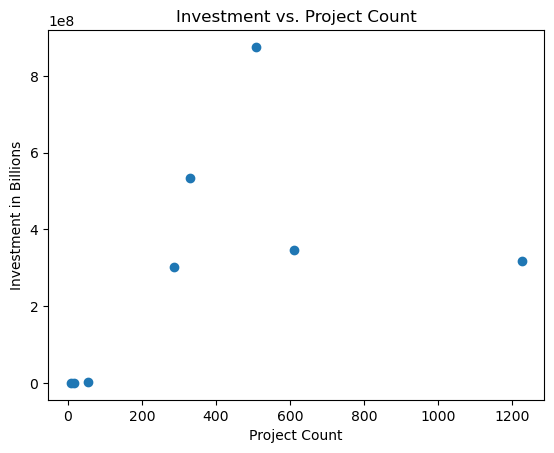

In [15]:
plt.scatter(Afghanistan_df['Project Count'], Afghanistan_df['Investment'])
plt.xlabel('Project Count')
plt.ylabel('Investment in Billions')
_ = plt.title('Investment vs. Project Count')

<Axes: xlabel='Fiscal Year'>

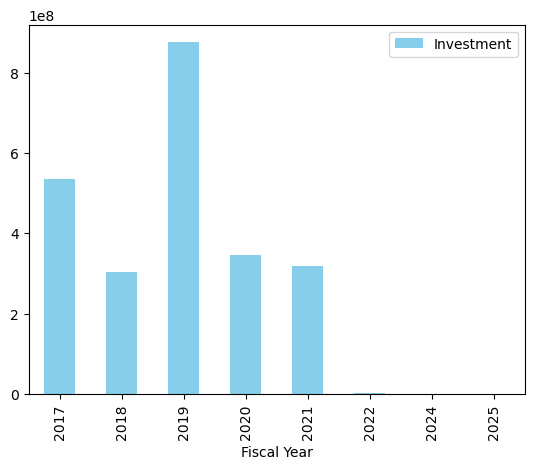

In [16]:
Afghanistan_reset = Afghanistan_df.reset_index(drop=True)
Afghanistan_reset.plot(kind='bar', x='Fiscal Year', y='Investment', color='skyblue')

<Axes: xlabel='Fiscal Year'>

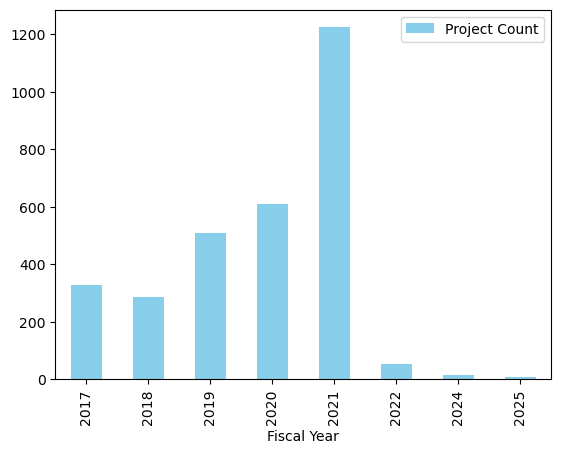

In [17]:
Afghanistan_reset.plot(kind='bar', x='Fiscal Year', y='Project Count', color='skyblue')

In [18]:
af_spending = Afghanistan_reset[['Fiscal Year','Investment']]
af_spending['Fiscal Year'] = pd.to_datetime(af_spending['Fiscal Year'], format='%Y')
af_spending = af_spending.rename(columns={'Investment':'y','Fiscal Year':'ds'})
af_spending

/var/folders/4p/rmrxtvt936v30345zcy84nw40000gn/T/ipykernel_2764/1144913531.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  af_spending['Fiscal Year'] = pd.to_datetime(af_spending['Fiscal Year'], format='%Y')


,ds,y
0,2017-01-01,5.344141e+08
1,2018-01-01,3.028574e+08
2,2019-01-01,8.758000e+08
3,2020-01-01,3.453970e+08
4,2021-01-01,3.181813e+08
5,2022-01-01,3.086722e+06
6,2024-01-01,5.592236e+05
7,2025-01-01,6.722842e+04


In [19]:
af_contracts= Afghanistan_reset[['Fiscal Year','Project Count']]
af_contracts['Fiscal Year'] = pd.to_datetime(af_contracts['Fiscal Year'], format='%Y')
af_contracts = af_contracts.rename(columns={'Project Count':'y','Fiscal Year':'ds'})
af_contracts

/var/folders/4p/rmrxtvt936v30345zcy84nw40000gn/T/ipykernel_2764/614660510.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  af_contracts['Fiscal Year'] = pd.to_datetime(af_contracts['Fiscal Year'], format='%Y')


,ds,y
0,2017-01-01,329
1,2018-01-01,286
2,2019-01-01,508
3,2020-01-01,611
4,2021-01-01,1225
5,2022-01-01,54
6,2024-01-01,16
7,2025-01-01,8


17:39:02 - cmdstanpy - INFO - Chain [1] start processing
17:39:02 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'ye' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


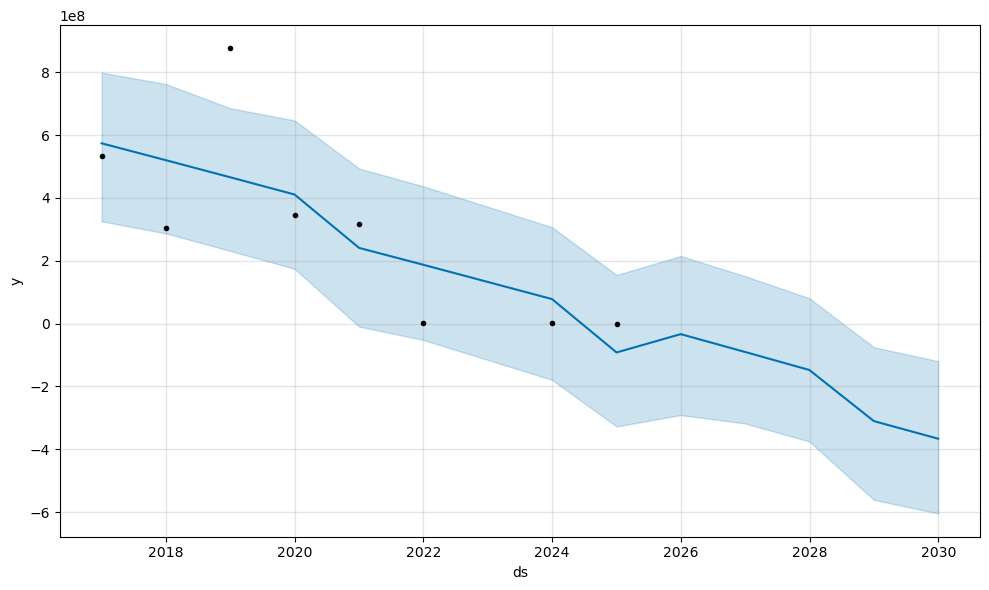

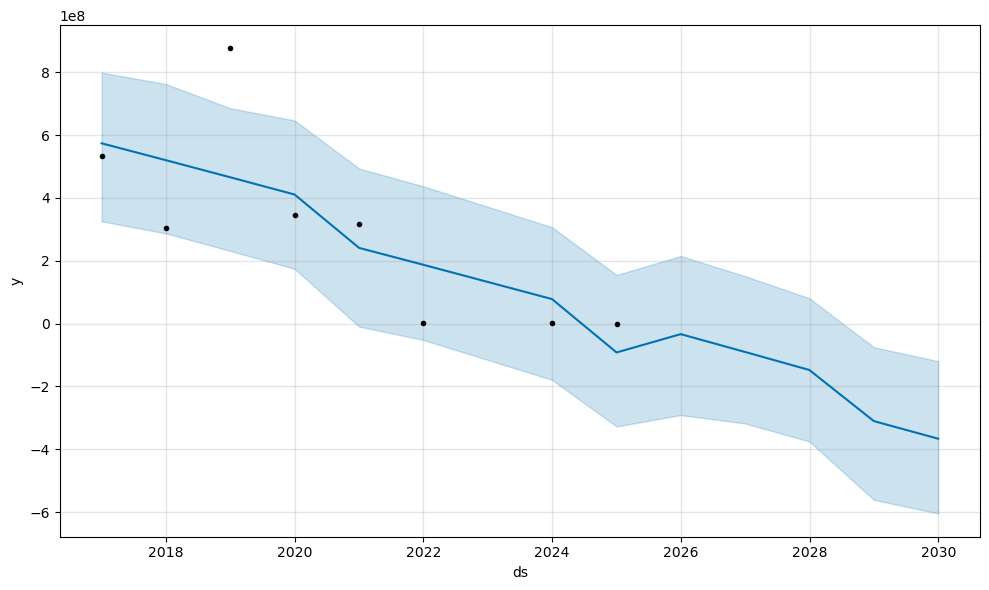

In [20]:
model_spending = Prophet()
model_spending.fit(af_spending)
future_spending = model_spending.make_future_dataframe(periods=5, freq='ye')
future_spending
forecast_spending = model_spending.predict(future_spending)
model_spending.plot(forecast_spending)


17:39:03 - cmdstanpy - INFO - Chain [1] start processing
17:39:03 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'ye' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


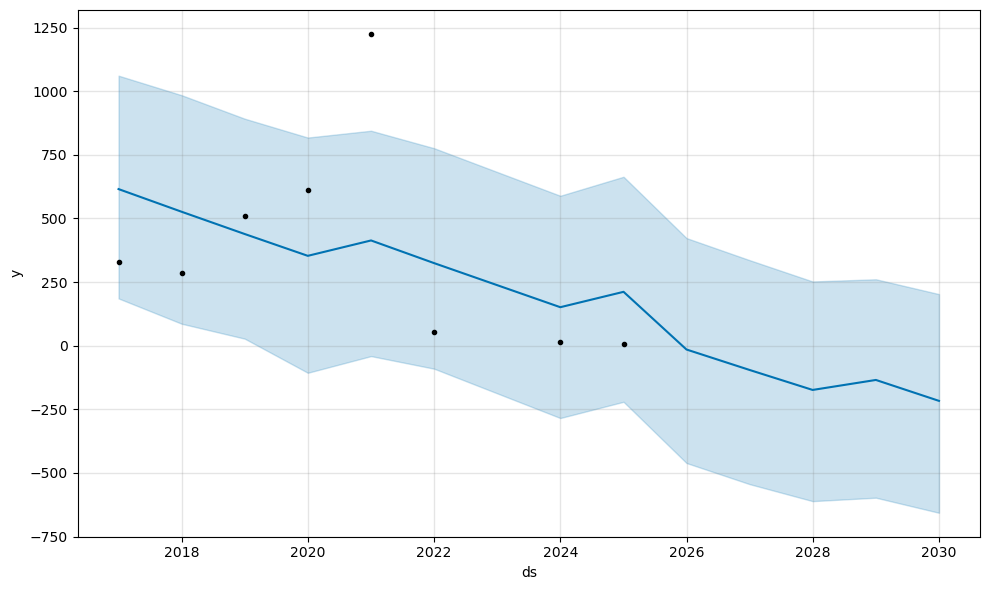

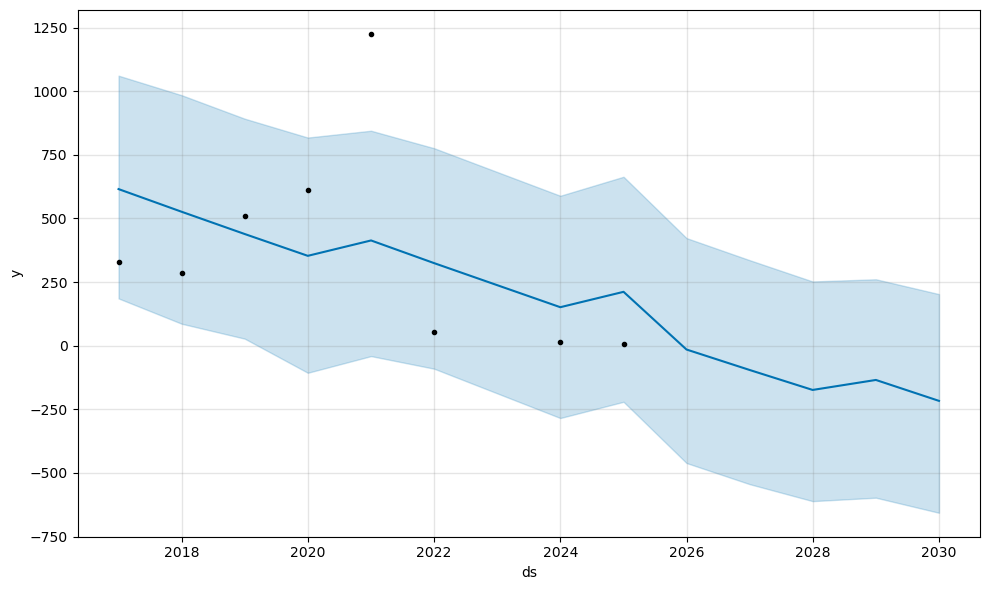

In [21]:
model_contracts = Prophet()
model_contracts.fit(af_contracts)
future_contracts = model_contracts.make_future_dataframe(periods=5, freq='ye')
future_contracts
forecast_contracts = model_contracts.predict(future_contracts)
model_contracts.plot(forecast_contracts)

In [43]:
af_data = new_df[['Fiscal Year','Project Global Practice', 'Supplier Contract Amount (USD)']]
af_data = af_data.rename(columns={'Fiscal Year':'ds'})
af_data

,ds,Project Global Practice,Supplier Contract Amount (USD)
0,2017,"Agriculture, Fishing and Forestry",27006.76
0,2017,"Industry, Trade and Services",27006.76
1,2017,Public Administration,151200.00
2,2017,Public Administration,312000.00
3,2017,Social Protection,76800.00
...,...,...,...
250991,2024,"Agriculture, Fishing and Forestry",20000.00
250991,2024,"Industry, Trade and Services",20000.00
250992,2025,Health,68564.34
250993,2025,Public Administration,47141.51


In [22]:
India_df = merged_df[merged_df['Borrower Country / Economy'] == 'India'].set_index('Fiscal Year',drop=True)
India_df.drop(columns=['Borrower Country / Economy'], inplace=True)
India_df.reset_index(inplace=True)
India_df=India_df.rename(columns={'Supplier Contract Amount (USD)':'Investment','Supplier ID':'Project Count'})
India_df

,Fiscal Year,Investment,Project Count
0,2017,3.263041e+09,4272
1,2018,4.128220e+09,5491
2,2019,2.514720e+09,9604
3,2020,3.690530e+09,10964
4,2021,3.080006e+09,14890
5,2022,2.090471e+09,9553
6,2023,9.581917e+08,7172
7,2024,6.127690e+08,5084
8,2025,1.085097e+08,260


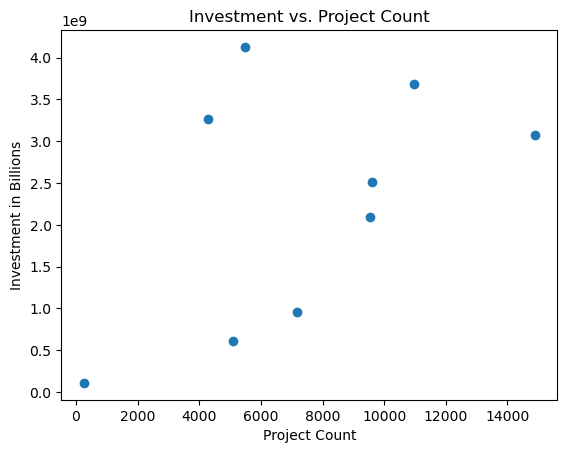

In [23]:
plt.scatter(India_df['Project Count'], India_df['Investment'])
plt.xlabel('Project Count')
plt.ylabel('Investment in Billions')
_ = plt.title('Investment vs. Project Count')

<Axes: xlabel='Fiscal Year'>

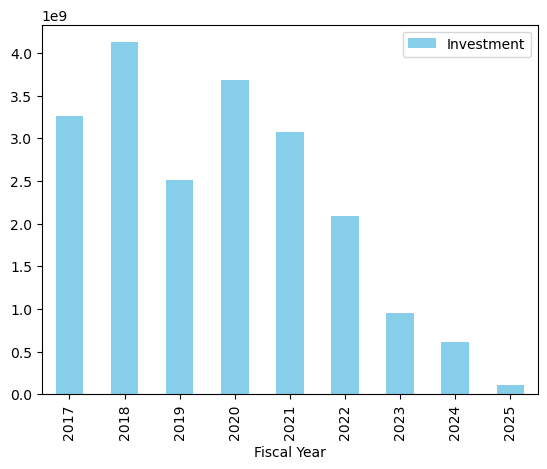

In [24]:
India_reset = India_df.reset_index(drop=True)
India_reset.plot(kind='bar', x='Fiscal Year', y='Investment', color='skyblue')

<Axes: xlabel='Fiscal Year'>

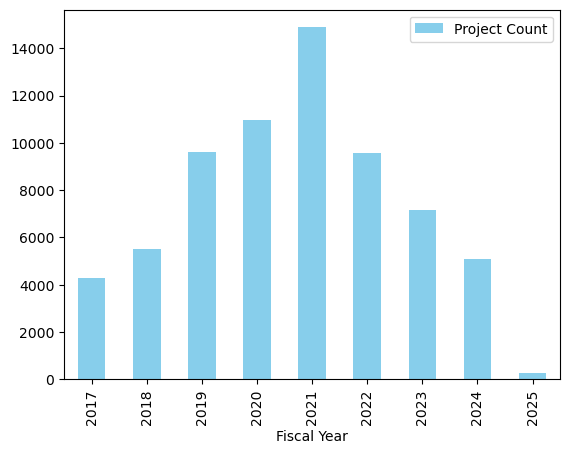

In [25]:
India_reset.plot(kind='bar', x='Fiscal Year', y='Project Count', color='skyblue')

In [26]:
India_spending = India_reset[['Fiscal Year','Investment']]
India_spending['Fiscal Year'] = pd.to_datetime(India_spending['Fiscal Year'], format='%Y')
India_spending = India_spending.rename(columns={'Investment':'y','Fiscal Year':'ds'})
India_spending

/var/folders/4p/rmrxtvt936v30345zcy84nw40000gn/T/ipykernel_2764/656769571.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  India_spending['Fiscal Year'] = pd.to_datetime(India_spending['Fiscal Year'], format='%Y')


,ds,y
0,2017-01-01,3.263041e+09
1,2018-01-01,4.128220e+09
2,2019-01-01,2.514720e+09
3,2020-01-01,3.690530e+09
4,2021-01-01,3.080006e+09
5,2022-01-01,2.090471e+09
6,2023-01-01,9.581917e+08
7,2024-01-01,6.127690e+08
8,2025-01-01,1.085097e+08


In [27]:
India_contracts= India_reset[['Fiscal Year','Project Count']]
India_contracts['Fiscal Year'] = pd.to_datetime(India_contracts['Fiscal Year'], format='%Y')
India_contracts = India_contracts.rename(columns={'Project Count':'y','Fiscal Year':'ds'})
India_contracts

/var/folders/4p/rmrxtvt936v30345zcy84nw40000gn/T/ipykernel_2764/3612175555.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  India_contracts['Fiscal Year'] = pd.to_datetime(India_contracts['Fiscal Year'], format='%Y')


,ds,y
0,2017-01-01,4272
1,2018-01-01,5491
2,2019-01-01,9604
3,2020-01-01,10964
4,2021-01-01,14890
5,2022-01-01,9553
6,2023-01-01,7172
7,2024-01-01,5084
8,2025-01-01,260


17:39:06 - cmdstanpy - INFO - Chain [1] start processing
17:39:06 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'ye' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


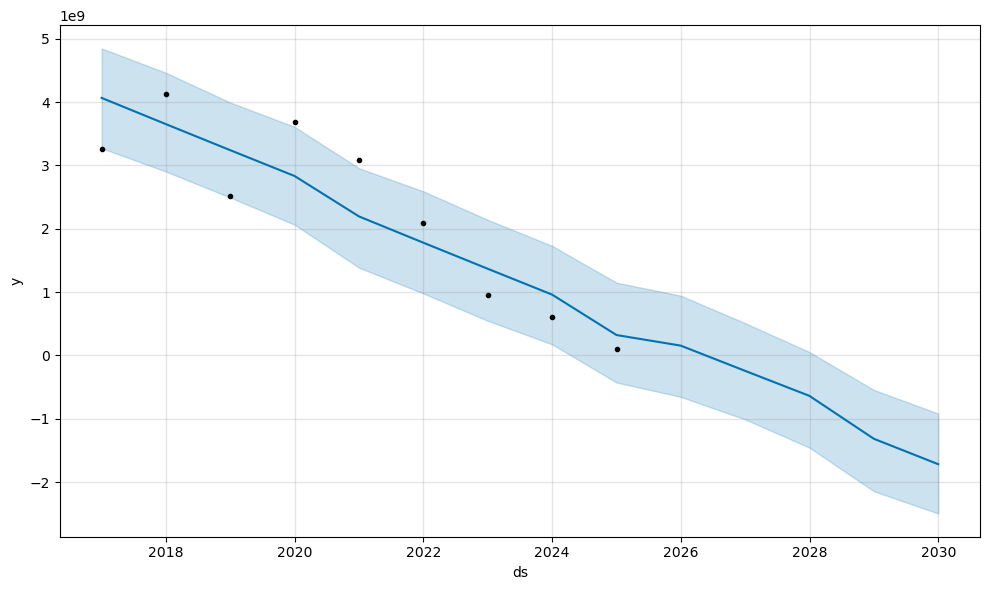

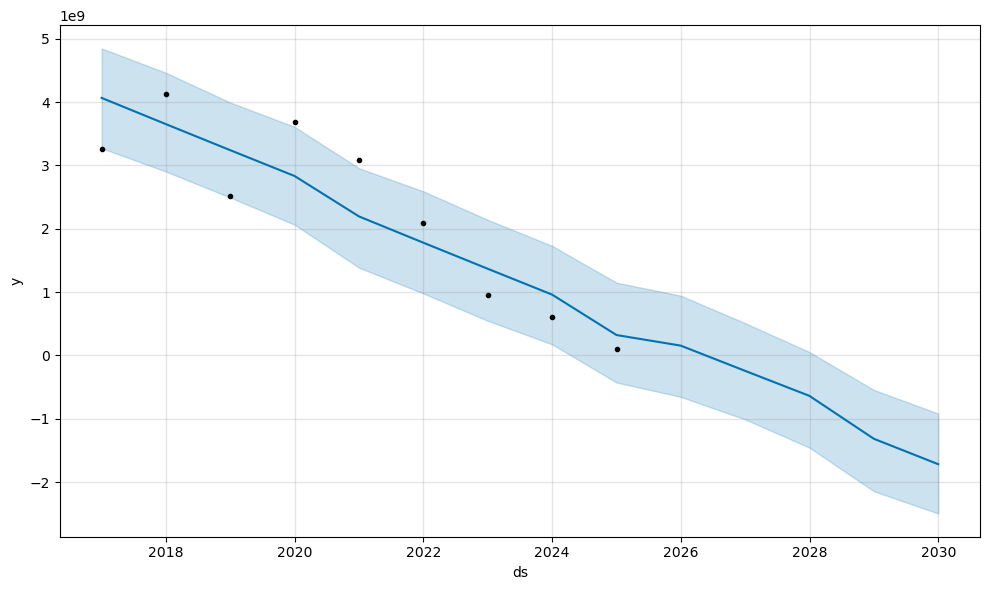

In [28]:
model_spending = Prophet()
model_spending.fit(India_spending)
future_spending = model_spending.make_future_dataframe(periods=5, freq='ye')
future_spending
forecast_spending = model_spending.predict(future_spending)
model_spending.plot(forecast_spending)

17:39:06 - cmdstanpy - INFO - Chain [1] start processing
17:39:07 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'ye' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


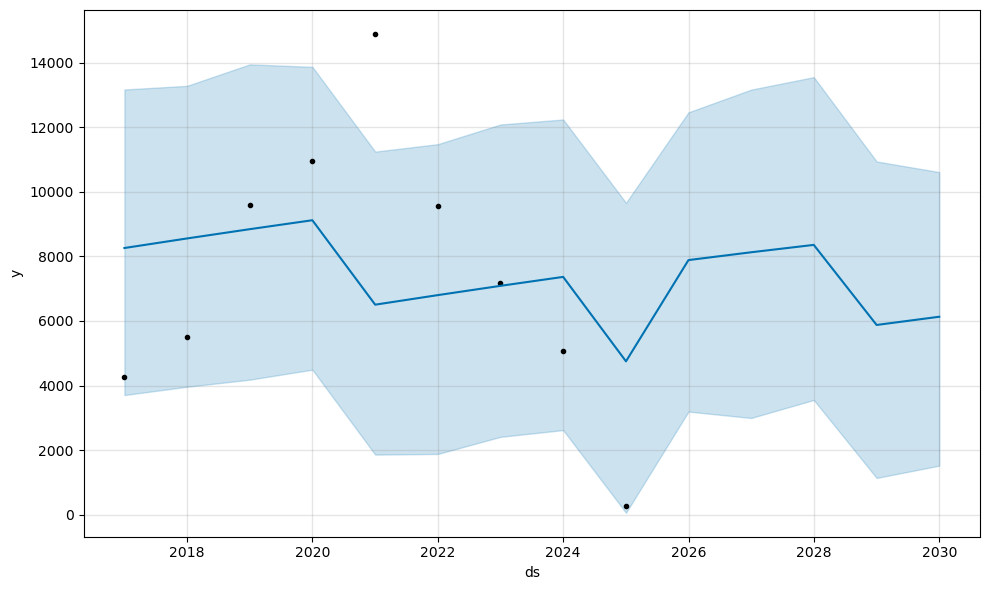

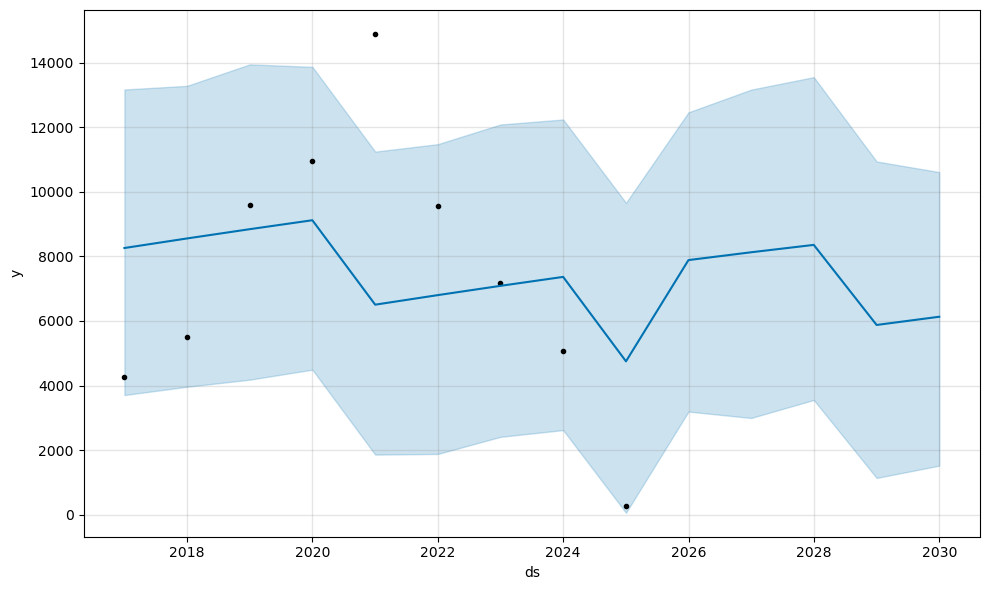

In [29]:
model_contracts = Prophet()
model_contracts.fit(India_contracts)
future_contracts = model_contracts.make_future_dataframe(periods=5, freq='ye')
future_contracts
forecast_contracts = model_contracts.predict(future_contracts)
model_contracts.plot(forecast_contracts)

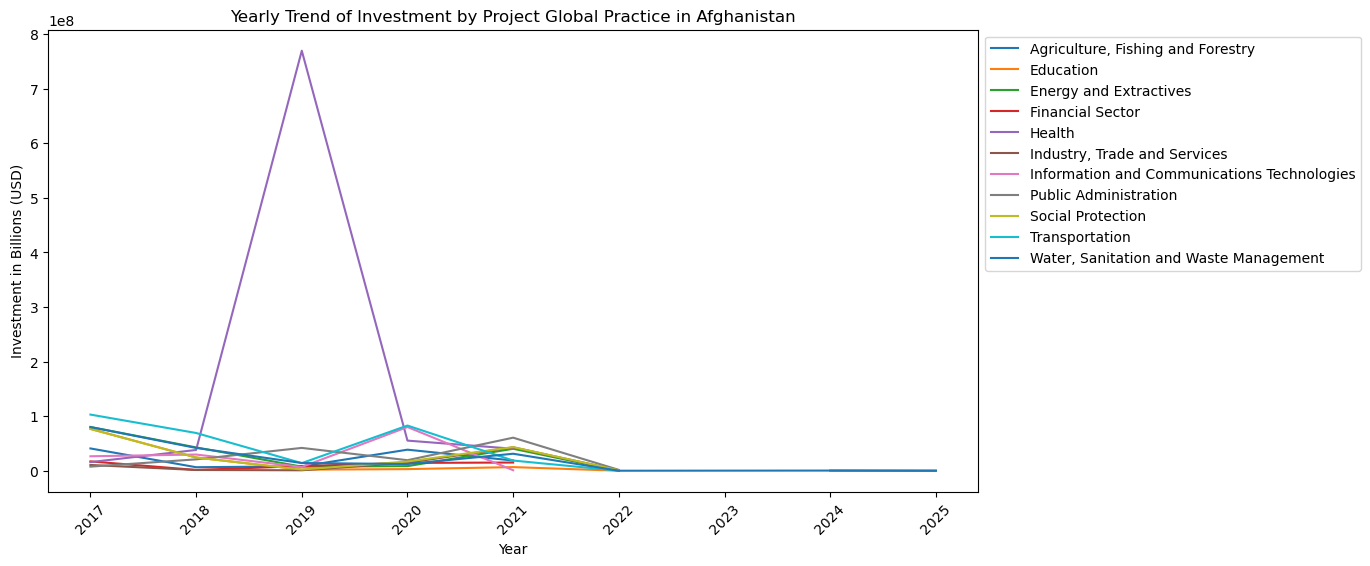

In [38]:
af_by_practice = pd.pivot_table(new_df[new_df['Borrower Country / Economy'] == 'Afghanistan'],values='Supplier Contract Amount (USD)',index='Fiscal Year',columns='Project Global Practice',aggfunc='sum')

af_by_practice.head()

af_by_practice.plot(figsize=(12, 6))
plt.title('Yearly Trend of Investment by Project Global Practice in Afghanistan')
plt.xlabel('Year')
plt.ylabel('Investment in Billions (USD)')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

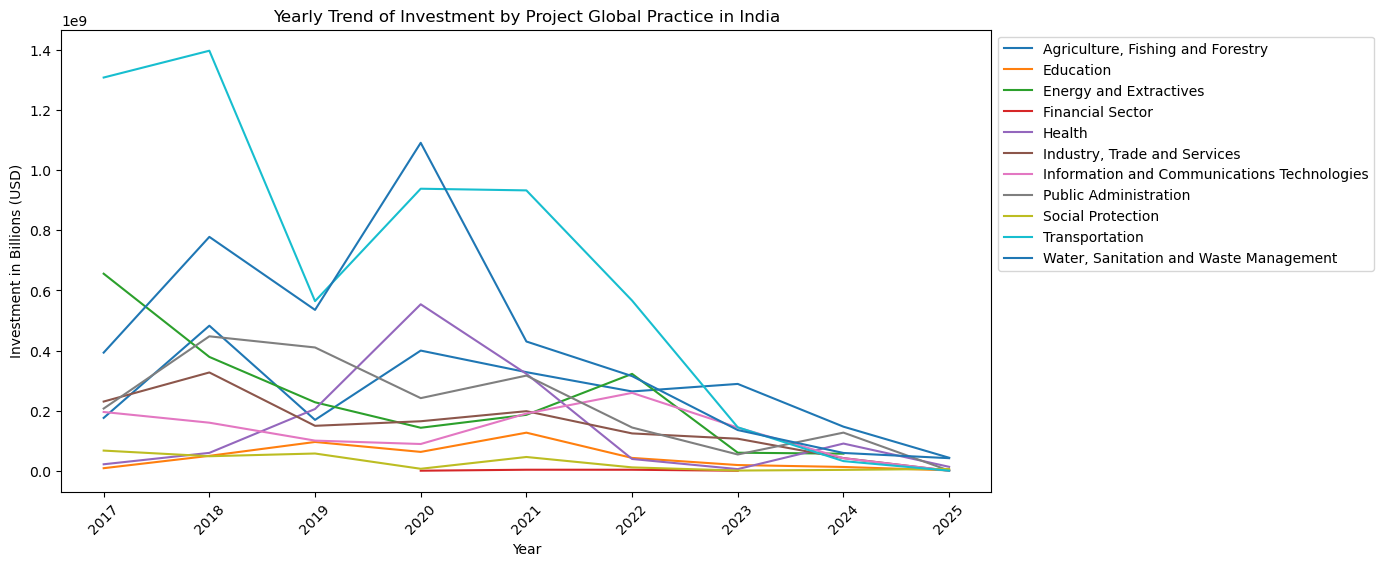

In [34]:
india_by_practice = pd.pivot_table(new_df[new_df['Borrower Country / Economy'] == 'India'],values='Supplier Contract Amount (USD)',index='Fiscal Year',columns='Project Global Practice',aggfunc='sum')

india_by_practice.head()

india_by_practice.plot(figsize=(12, 6))
plt.title('Yearly Trend of Investment by Project Global Practice in India')
plt.xlabel('Year')
plt.ylabel('Investment in Billions (USD)')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

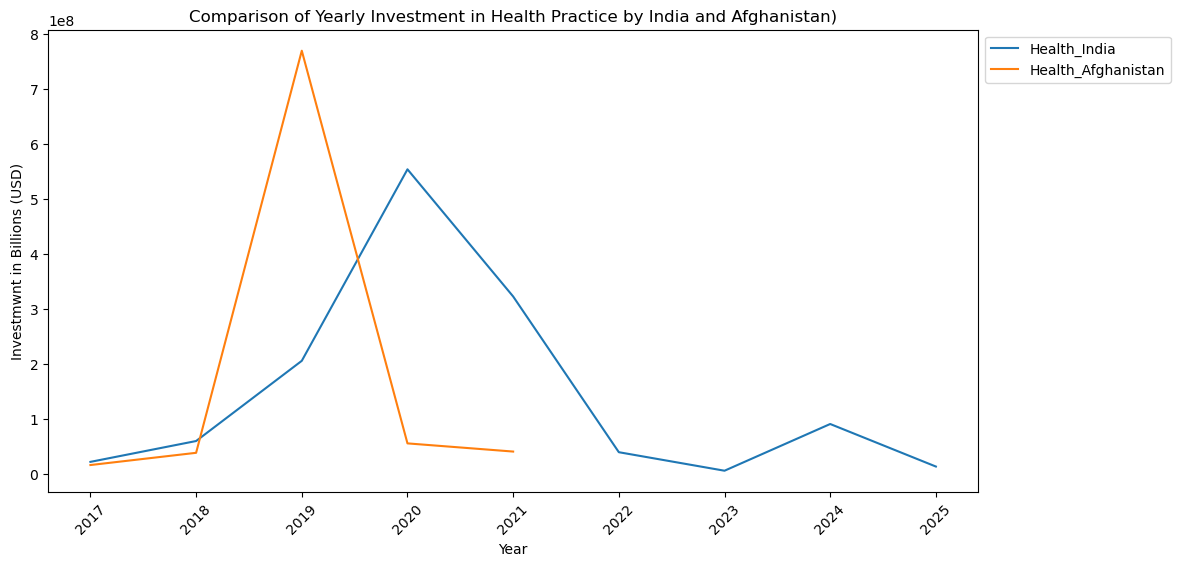

In [52]:
merged_pivot_table = pd.merge(india_by_practice, af_by_practice, on='Fiscal Year', how='outer', suffixes=('_India', '_Afghanistan'))

# Select only the 'Health' column for both countries
health_trend = merged_pivot_table[['Health_India', 'Health_Afghanistan']]

# Plot the yearly trend for Health
health_trend.plot(figsize=(12, 6))
plt.title('Comparison of Yearly Investment in Health Practice by India and Afghanistan)')
plt.xlabel('Year')
plt.ylabel('Investmwnt in Billions (USD)')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()